In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd

In [2]:
## Scrap the Data from Internet
html = urlopen('https://en.wikipedia.org/wiki/Energy_in_the_United_States')
soup = BeautifulSoup(html.read(),'html.parser')
tables = soup.find_all('table', {'class':'wikitable'})

# Search through the tables for the one with the headings we want.
for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[:4] == ['Year', 'Fossil fuel', 'Nuclear', 'Renewable']:
        break

# Extract the columns we want and write to a semicolon-delimited text file.
column_list = ['Year','Coal','Oil','Gas','Subtotal_fossil','Nuclear','Hydro',\
'Geothermal','Solar','Wind','Wood','Bio_other','Subtotal_renewable', 'Misc','Total']
energy = pd.DataFrame(index = list(range(20)), columns = column_list)
data_list = list()
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue
    Data = [td.text.strip() for td in tds]
    data_list.append(Data)
data_list = np.array(data_list[0:20])
count = 0 
for col in column_list:
    energy[col] = data_list[:,count]
    count += 1
energy = energy.drop([1,3,5,7,13,18])
# Edit the wrong data
energy['Year'][0] = '2018'
#energy.to_csv (r'C:\Users\yanbo_000\Desktop\143Project\energy_consumpton_USA.csv', index = None, header=True)
html.close()

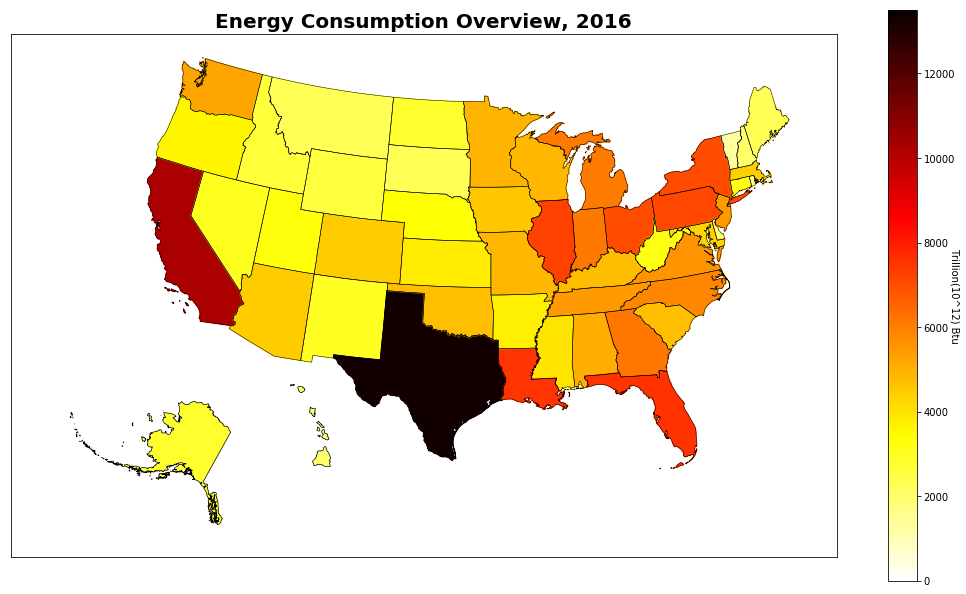

<Figure size 432x288 with 0 Axes>

In [3]:
'''
    projection: Lambert Conformal Projection (lcc)
    llcrnrlon: longitude of lower left hand corner of the desired map domain (-119)
    llcrnrlat:latitude of lower left hand corner of the desired map domain (22)
    urcrnrlon:longitude of upper right hand corner of the desired map domain (64)
    urcrnrlat:latitude of upper right hand corner of the desired map domain (49)
    lon_0:center of desired map domain (-95).
    resolution: high
'''
fig = plt.figure(figsize=(18.5, 10.5))
m = Basemap(llcrnrlon=-125,llcrnrlat=15,urcrnrlon=-60,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='l')
# draw state boundaries.
# data from U.S Census Bureau
shp_info = m.readshapefile('cb_2018_us_state_5m','states',drawbounds=True)
# Energy comsumption by 2016
# https://www.eia.gov/state/seds/sep_sum/html/pdf/sum_btu_1.pdf
energyConsumption = {
'New Jersey':  2219.4,
'Rhode Island':   186.2,
'Massachusetts':   1422.8,
'Connecticut':    723.9,
'Maryland':   1359.3,
'New York':    3661.5,
'Delaware':    273.5,
'Florida':     4240.2,
'Ohio':  3684.8,
'Pennsylvania':  3755.3,
'Illinois':    3907.1,
'California':  7830.3,
'Hawaii':  282.9,
'Virginia':    2332.0,
'Michigan':    2751.6,
'Indiana':    2802.3,
'North Carolina':  2553.8,
'Georgia':     2838.9,
'Tennessee':   2211.3,
'New Hampshire':   300.9,
'South Carolina':  1653.3,
'Louisiana':   4205.3,
'Kentucky':   1702.4,
'Wisconsin':  1781.1,
'Washington':  2058.2,
'Alabama':     1933.6,
'Missouri':    1780.0,
'Texas':   13183.5,
'West Virginia':   766.2,
'Vermont':     128.7,
'Minnesota':  1806.9,
'Mississippi':   1166.3,
'Iowa':  1529.8,
'Arkansas':    1056.5,
'Oklahoma':    1636.0,
'Arizona':     1470.6,
'Colorado':    1484.6,
'Maine':  387.8,
'Oregon':  977.5,
'Kansas':  1093.0,
'Utah':  810.1,
'Nebraska':    868.3,
'Nevada':  679.1,
'Idaho':   528.5,
'New Mexico':  667.8,
'South Dakota':  383.2,
'North Dakota':  586.4,
'Montana':     394.5,
'Wyoming':      502.9,
'Alaska':     600}
# choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.hot # use 'hot' colormap
vmin = 0; vmax = 13500 # set range.
for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico', 'United States Virgin Islands',\
                         'Guam','Commonwealth of the Northern Mariana Islands','American Samoa']:
        pop = energyConsumption[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
# cycle through state names, color each one.
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico', 'United States Virgin Islands',\
                         'Guam','Commonwealth of the Northern Mariana Islands','American Samoa']:
        # Offset Alaska and Hawaii to the lower-left corner. 
        if statenames[nshape] == 'Alaska':
        # Alaska is too big. Scale it down to 35% first, then transate it. 
            seg1 = list(map(lambda x : (0.35 * x[0] + 1100000, 0.35 * x[1]-1300000), seg))
            color = rgb2hex(colors[statenames[nshape]]) 
            poly = Polygon(seg1,facecolor=color,edgecolor='black',linewidth = 0.7)
            ax.add_patch(poly)
        if statenames[nshape] == 'Hawaii':
            seg1 = list(map(lambda x: (x[0] + 5000000, x[1]-1400000), seg))
            color = rgb2hex(colors[statenames[nshape]]) 
            poly = Polygon(seg1,facecolor=color,edgecolor='black',linewidth = 0.7)
            ax.add_patch(poly)
        else:   
            color = rgb2hex(colors[statenames[nshape]]) 
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            ax.add_patch(poly)
            
# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='hot_r' , norm=plt.Normalize(vmin=0, vmax=13500))
sm._A = []
cbar = fig.colorbar(sm)
cbar.set_label('Trillion(10^12) Btu', rotation=270)
        
plt.title('Energy Consumption Overview, 2016',fontsize = 20, fontweight='bold')
plt.show()
plt.savefig('plt_energyConsumption.png')

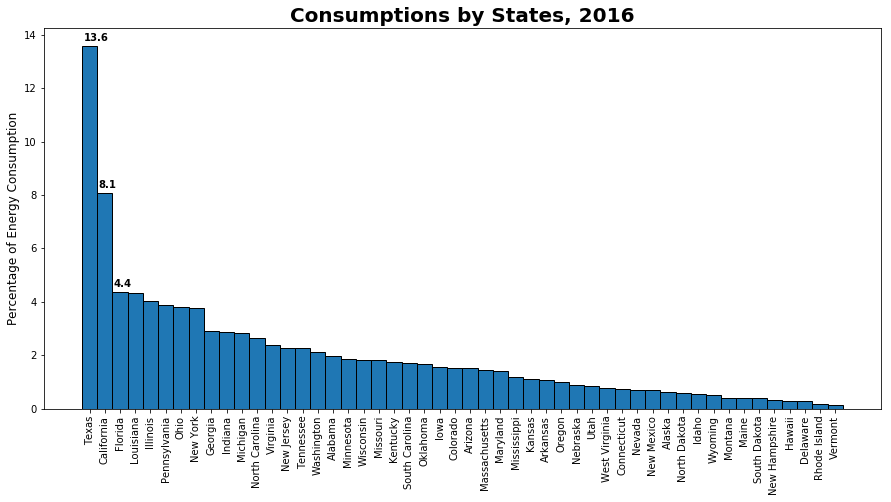

In [4]:
# # Plot the bar plot # #
total = sum(energyConsumption.values())
sort_by_consumption = sorted(energyConsumption.items(),key=lambda x:x[1],reverse=True)
percentage = list(x[1] * 100 / total for x in sort_by_consumption)
names = list(x[0] for x in sort_by_consumption)
nfeatures = len(energyConsumption)
plt.figure(figsize=(15,7))
plt.bar(range(nfeatures), percentage, width=1, \
        tick_label = names, edgecolor = 'black') # plot features importances
for v in range(len(percentage)-47):
    value = '%0.1f' % percentage[v]
    plt.text(x = v-0.4, y = percentage[v] + 0.2, s = value, color='black', fontweight='bold',fontsize =10)
plt.ylabel('Percentage of Energy Consumption', fontsize=12)
plt.title('Consumptions by States, 2016',fontsize = 20, fontweight='bold')
plt.xticks(rotation = 90)
plt.show()

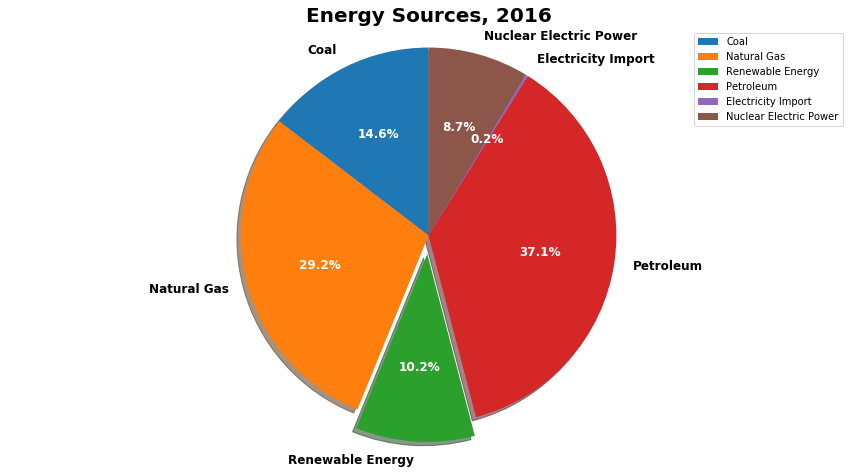

In [5]:
# # Pie Chart # #
energySource = {
'Coal': 14221.7,
'Natural Gas': 28438.6,
'Renewable Energy': 9965.5,
'Petroleum': 36070.2,
'Electricity Import': 205.6,
'Nuclear Electric Power': 8426.8
}
# Data to plot
plt.figure(figsize=(15,8))
labels = energySource.keys()
sizes = energySource.values()
explode = (0, 0, 0.1, 0, 0, 0)  # explode 1st slice

# Plot
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, \
                        autopct='%1.1f%%', shadow=True, startangle = 90)
plt.legend(labels, loc="best")
plt.setp(texts, size=12, weight="bold", color = 'black')
plt.setp(autotexts, size=12, weight="bold", color = 'white')
plt.title('Energy Sources, 2016',fontsize = 20, fontweight='bold')
plt.axis('equal')
plt.show()

In [17]:
def convert_to_list(pd):
    for i in range(len(pd)):
        string = str(pd[i])
        num = string.replace(',','')
        num = float(num)
        pd[i] = num
    return pd

3723.8
3836
4188.0
4152.2
3984.4
4151.0
4138.4
4095
4112.7
4146.2
4144.27
4137.10
4090.58
4177.81


Text(0,0.5,'TWh')

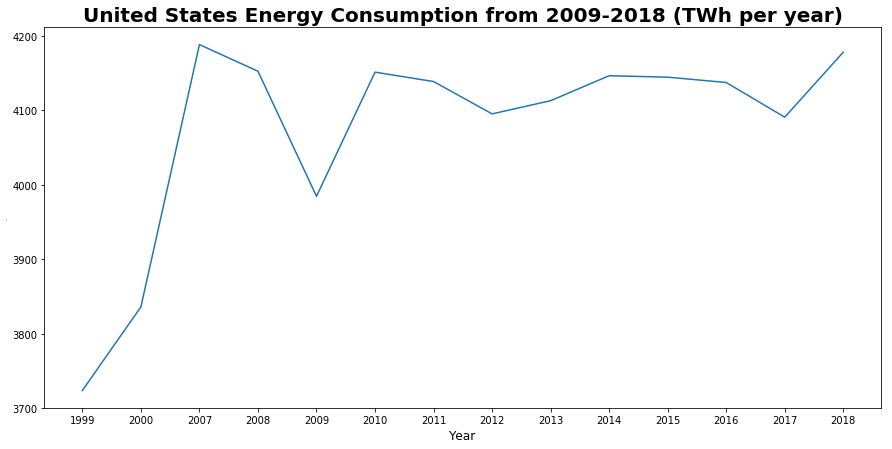

In [7]:
plt.figure(figsize=(15,7))
total_energy = list(energy['Total'])[::-1]
year = list(energy['Year'])[::-1]
total_energy = convert_to_list(total_energy)
plt.plot(year, total_energy)
plt.title('United States Energy Consumption from 2009-2018 (TWh per year)', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('TWh', fontsize=1)

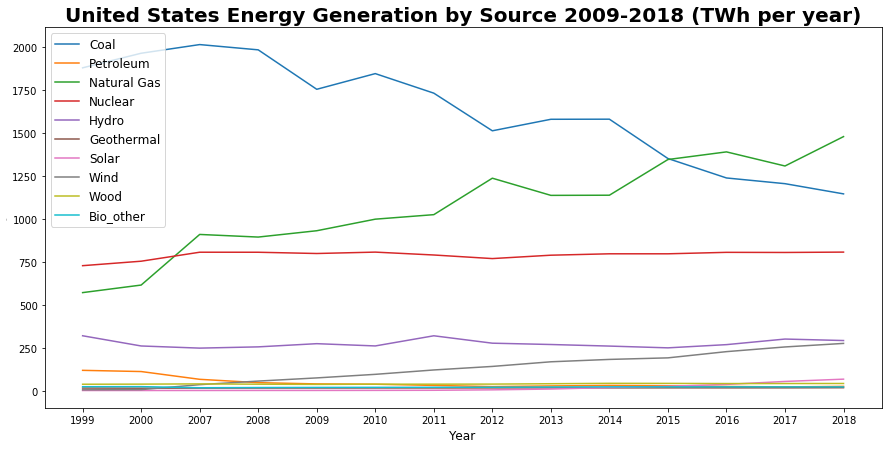

In [25]:
column_list = ['Year','Coal','Oil','Gas','Subtotal_fossil','Nuclear','Hydro',\
'Geothermal','Solar','Wind','Wood','Bio_other','Subtotal_renewable', 'Misc','Total']
plt.figure(figsize=(15,7))
Coal = convert_to_list(list(energy['Coal'])[::-1])
Petroleum = convert_to_list(list(energy['Oil'])[::-1])
NaturalGas = list(energy['Gas'])[::-1]
NaturalGas[0] = '571.0'
NaturalGas = convert_to_list(NaturalGas)
Nuclear = convert_to_list(list(energy['Nuclear'])[::-1])
Hydro = convert_to_list(list(energy['Hydro'])[::-1])
Geothermal = convert_to_list(list(energy['Geothermal'])[::-1])
Solar = convert_to_list(list(energy['Solar'])[::-1])
Wind = convert_to_list(list(energy['Wind'])[::-1])
Wood = convert_to_list(list(energy['Wood'])[::-1])
Bio_other = convert_to_list(list(energy['Bio_other'])[::-1])
plt.plot(year, Coal)
plt.plot(year, Petroleum)
plt.plot(year, NaturalGas)
plt.plot(year, Nuclear)
plt.plot(year, Hydro)
plt.plot(year, Geothermal)
plt.plot(year, Solar)
plt.plot(year, Wind)
plt.plot(year, Wood)
plt.plot(year, Bio_other)
plt.title('United States Energy Generation by Source 2009-2018 (TWh per year)', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('TWh', fontsize=1)
plt.legend(('Coal','Petroleum','Natural Gas','Nuclear','Hydro','Geothermal','Solar','Wind','Wood','Bio_other'), fontsize=12, loc=2)

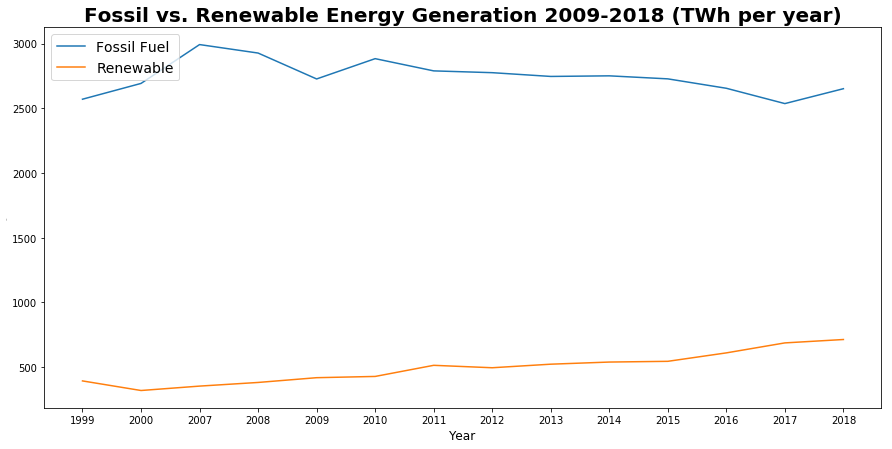

In [28]:
plt.figure(figsize=(15,7))
fossil = convert_to_list(list(energy['Subtotal_fossil'])[::-1])
renewable = convert_to_list(list(energy['Subtotal_renewable'])[::-1])
plt.plot(year, fossil)
plt.plot(year, renewable)
plt.title('Fossil vs. Renewable Energy Generation 2009-2018 (TWh per year)', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('TWh', fontsize=1)
plt.legend(('Fossil Fuel','Renewable'), fontsize=14, loc=2)